## Imports section

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
from pyproj import Proj, Transformer
from geopy.distance import geodesic
import numpy as np
import matplotlib.pyplot as plt
import datetime

## Reading the files and preprocessing

In [2]:
# Ids of the districts except from poblads del norte and poblados del sur
quality_ids = [8,10,12,71,135,87,151,119,9,14,1,23,216,6,13,55,103,183]

# Ids of the most important districts - Poblados Maritimo, Algiros, Camins al Grau, Benimaclet
key_districts_ids = [183,55,13,71]

In [3]:
# Read the data about the Valencia districts
districts_gdf = gpd.read_file('../data/districts.geojson')

In [4]:
# Removing the districts where the buses does not ride
districts_gdf = districts_gdf[~districts_gdf['objectid'].isin([199, 217])]

In [5]:
# Leaving only the districts that are of interest
districts_gdf = districts_gdf[['objectid', 'nombre', 'geometry']]

Districts_gdf Geopandas Dataframe collects the data about the id and name of the district in combination with the polygon coordinates that represent the district.

In [6]:
districts_gdf.head(1)

,objectid,nombre,geometry
0,8,EL PLA DEL REAL,"POLYGON ((-0.36229 39.48483, -0.36274 39.48389..."


In [7]:
# Read the data about the Valencia bus lines
trips_df = pd.read_csv('../data/trips.csv')
shapes_df = pd.read_csv('../data/shapes.csv')

In [8]:
# Drop the unnecessary columns
trips_df.drop(columns=['service_id', 'trip_id', 'trip_headsign', 'direction_id', 'block_id'], inplace=True)

In [9]:
# Merge the shape coordinates with the trips data
trips_df = trips_df.merge(shapes_df, on='shape_id')

trips_df has information about the points on the routes. Points are assigned to the route.

In [10]:
trips_df.head(1)

,route_id,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,23,SHP_1033_V,39.432336,-0.376358,0,0.0


In [11]:
# Convert trips_df and shapes_df to GeoDataFrames
trips_gdf = gpd.GeoDataFrame(trips_df, geometry=gpd.points_from_xy(trips_df['shape_pt_lon'], trips_df['shape_pt_lat']))
trips_gdf.drop(columns=['shape_pt_lat', 'shape_pt_lon'], inplace=True)
trips_gdf = trips_gdf.set_crs(epsg=4326)

trips-gdf is a trips_df after transmission to the GeoPandas Dataframe. Now it contains geometry column that represents the point on the map.

In [12]:
trips_gdf.head(1)

,route_id,shape_id,shape_pt_sequence,shape_dist_traveled,geometry
0,23,SHP_1033_V,0,0.0,POINT (-0.37636 39.43234)


In [13]:
# Spatial join with districts_gdf based on intersection
final_joined_gdf = gpd.sjoin(trips_gdf, districts_gdf, how='inner', predicate='intersects')

After the spatial join final_joined_gdf has a information about the id and the name of the districts it is in

In [14]:
final_joined_gdf.head(1)

,route_id,shape_id,shape_pt_sequence,shape_dist_traveled,geometry,index_right,objectid,nombre
0,23,SHP_1033_V,0,0.0,POINT (-0.37636 39.43234),13,167,POBLATS DEL SUD


## Routes per district

district_routes_count is a geodataframe that assignes the number of routes that go through the district.

In [15]:
# Group by district and count unique route_id values
district_routes_count = final_joined_gdf.groupby('nombre')['route_id'].nunique().reset_index()
district_routes_count.rename(columns={'route_id': 'routes_count'}, inplace=True)

In [16]:
district_routes_count.head(1)

,nombre,routes_count
0,ALGIROS,11


## Stops per district

In [17]:
# Read the data about the Valencia stops
stops_df = pd.read_csv('../data/stopsData.csv')

The stops_df contains information about the stops in Valencia and their coordinates

In [18]:
stops_df.head(1)

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station
0,10,10,Mediterrani,NaN,4372035.552,729833.633,NaN,NaN,0,NaN


In [19]:
# Leave only valuable columns
stops_df = stops_df[['stop_id', 'stop_name', 'stop_lat', 'stop_lon']]

In [20]:
# Create a GeoDataFrame from the stops data
stops_gdf = gpd.GeoDataFrame(stops_df, geometry=gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat))

In [21]:
# Remove the unnecessary columns
stops_gdf.drop(columns=['stop_name', 'stop_lat', 'stop_lon'], inplace=True)

In [22]:
stops_gdf.head(1)

,stop_id,geometry
0,10,POINT (729833.633 4372035.552)


In [23]:
# Define the EPSG codes for the source (EPSG 3857) and target (EPSG 4326) CRS
source_crs = Proj('epsg:25830')
target_crs = Proj('epsg:4326')

In [24]:
# Transform the coordinates of the stops to the target CRS
for i, row in stops_gdf.iterrows():
    x = row.geometry.x
    y = row.geometry.y
    transformer = Transformer.from_proj(source_crs, target_crs)
    lon, lat = transformer.transform(x, y)
    stops_gdf.at[i, 'geometry'] = Point(lat, lon)

In [25]:
# Set the epsg to 4326
stops_gdf = stops_gdf.set_crs(epsg=4326)

In [26]:
# Merge the stops with the districts
stops_in_districts = gpd.sjoin(stops_gdf, districts_gdf, how='inner', predicate='within')

stops_in_districts is a geoDataFrame that stores information about the stop and the district it is in

In [27]:
stops_in_districts.head(1)

,stop_id,geometry,index_right,objectid,nombre
0,10,POINT (-0.32831 39.46723),21,183,POBLATS MARITIMS


In [28]:
# Count the surface area of each district
warnings.filterwarnings('ignore')
districts_gdf['surface_area'] = districts_gdf['geometry'].area * 10**4

In [29]:
# Artificially reduce the area of the Albufera district
albufera_lake_area = 27
# Subtract the area of the Albufera lake from the Poblats del Sud district
districts_gdf.loc[districts_gdf['objectid'] == 167, 'surface_area'] -= albufera_lake_area

In [30]:
# Group the stops by the districts and count the stops in each district
stops_in_districts_grouped = stops_in_districts.groupby('nombre').size().reset_index(name='stops_count')

stops_in_district_grouped provides us with information how many stops are in each district

In [31]:
stops_in_districts_grouped.head(1)

,nombre,stops_count
0,ALGIROS,46


In [32]:
# Count the total number of stops, total area of the districts and calculate the density of stops per square kilometer
all_stops = stops_in_districts_grouped['stops_count'].sum()
total_area = districts_gdf['surface_area'].sum()
density = all_stops / total_area

print(f'The total number of stops is {all_stops}')
print(f'The total area of the districts is {total_area:.2f} km^2')
print(f'The density of stops per square kilometer is {density:.2f} stops/km^2')

The total number of stops is 1114
The total area of the districts is 112.94 km^2
The density of stops per square kilometer is 9.86 stops/km^2


In [33]:
# Count the total number of stops, total area and the density of stops per square kilometer in the districts not far away from the city centre
centre_districts_stops_df = stops_in_districts[stops_in_districts['objectid'].isin(quality_ids)]
centre_districts_df = districts_gdf[districts_gdf['objectid'].isin(quality_ids)]
centre_districts_stops_grouped = centre_districts_stops_df.groupby('nombre').size().reset_index(name='stops_count')

centre_districts_all_stops = centre_districts_stops_grouped['stops_count'].sum()
centre_districts_total_area = centre_districts_df['surface_area'].sum()
centre_districts_density = centre_districts_all_stops / centre_districts_total_area

print(f'The total number of stops in the districts after dropping poblados the sur and norte is {centre_districts_all_stops}')
print(f'The total area of the districts after dropping poblados the sur and norte is {centre_districts_total_area:.2f} km^2')
print(f'The density of stops per square kilometer in the districts after dropping poblados the sur and norte is {centre_districts_density:.2f} stops/km^2')

The total number of stops in the districts after dropping poblados the sur and norte is 1002
The total area of the districts after dropping poblados the sur and norte is 59.50 km^2
The density of stops per square kilometer in the districts after dropping poblados the sur and norte is 16.84 stops/km^2


In [34]:
# Count the total number of stops, total area and the density of stops per square kilometer in the key districts
key_districts_stops_df = stops_in_districts[stops_in_districts['objectid'].isin(key_districts_ids)]
key_districts_df = districts_gdf[districts_gdf['objectid'].isin(key_districts_ids)]
key_districts_stops_grouped = key_districts_stops_df.groupby('nombre').size().reset_index(name='stops_count')

key_districts_all_stops = key_districts_stops_grouped['stops_count'].sum()
key_districts_total_area = key_districts_df['surface_area'].sum()
key_districts_density = key_districts_all_stops / key_districts_total_area

print(f'The total number of stops in the key districts is {key_districts_all_stops}')
print(f'The total area of the key districts is {key_districts_total_area:.2f} km^2')
print(f'The density of stops per square kilometer in the key districts is {key_districts_density:.2f} stops/km^2')

The total number of stops in the key districts is 224
The total area of the key districts is 16.08 km^2
The density of stops per square kilometer in the key districts is 13.93 stops/km^2


## Distance to the closest bus stop

In [35]:
key_districts_stops_df = key_districts_stops_df.set_crs(epsg=4326)

In [36]:
# Initialize variables to store total distance and count of distances
total_distance = 0
count = 0

# Iterate over each stop
for i, stop in key_districts_stops_df.iterrows():
    # Initialize variables to store the closest distance and stop
    closest_distance = np.inf
    closest_stop = None
    
    # Calculate distances to all other stops
    for j, other_stop in key_districts_stops_df.iterrows():
        if i != j:  # Skip the same stop
            distance = geodesic((stop['geometry'].y, stop['geometry'].x),
                                (other_stop['geometry'].y, other_stop['geometry'].x)).kilometers
            # Check if it's the closest stop so far and if it's not too close to the stop
            if distance < closest_distance and distance > 0.1:
                closest_distance = distance
                closest_stop = other_stop
    
    # Add the closest distance to total distance
    total_distance += closest_distance
    count += 1

# Calculate average distance
average_distance = total_distance / count if count > 0 else 0

# Print the average distance
print("Average distance between neighboring stops:", average_distance, "kilometers")

Average distance between neighboring stops: 0.16199182852052507 kilometers


## Plotting the routes and stops per district data

In [37]:
# Merging the stops with the districts
merged_df = districts_gdf.merge(stops_in_districts_grouped, on='nombre')

In [38]:
# Drop the unnecessary columns
merged_df.drop(columns='objectid', inplace=True)

In [39]:
# Display the merged data
merged_df.head(1)

,nombre,geometry,surface_area,stops_count
0,EL PLA DEL REAL,"POLYGON ((-0.36229 39.48483, -0.36274 39.48389...",1.771051,55


In [40]:
# Removing the far from the city districts
merged_df = merged_df[~merged_df['nombre'].isin(['POBLATS DEL NORD', 'POBLATS DEL SUD'])]

In [41]:
# Calculating the stops per square kilometer
merged_df['stops_per_km2'] = (merged_df['stops_count'] / merged_df['surface_area']).round(2)

In [42]:
routes_merged_df = districts_gdf.merge(district_routes_count, on='nombre')

In [43]:
routes_merged_df = routes_merged_df[['nombre', 'routes_count', 'geometry', 'surface_area']]

routes_merged_df stores the information about the district, its borders, its area and the number of routes that go through it

In [44]:
routes_merged_df.head(1)

,nombre,routes_count,geometry,surface_area
0,EL PLA DEL REAL,24,"POLYGON ((-0.36229 39.48483, -0.36274 39.48389...",1.771051


In [45]:
# Removing the far from the city districts
routes_merged_df = routes_merged_df[~routes_merged_df['nombre'].isin(['POBLATS DEL NORD', 'POBLATS DEL SUD'])]

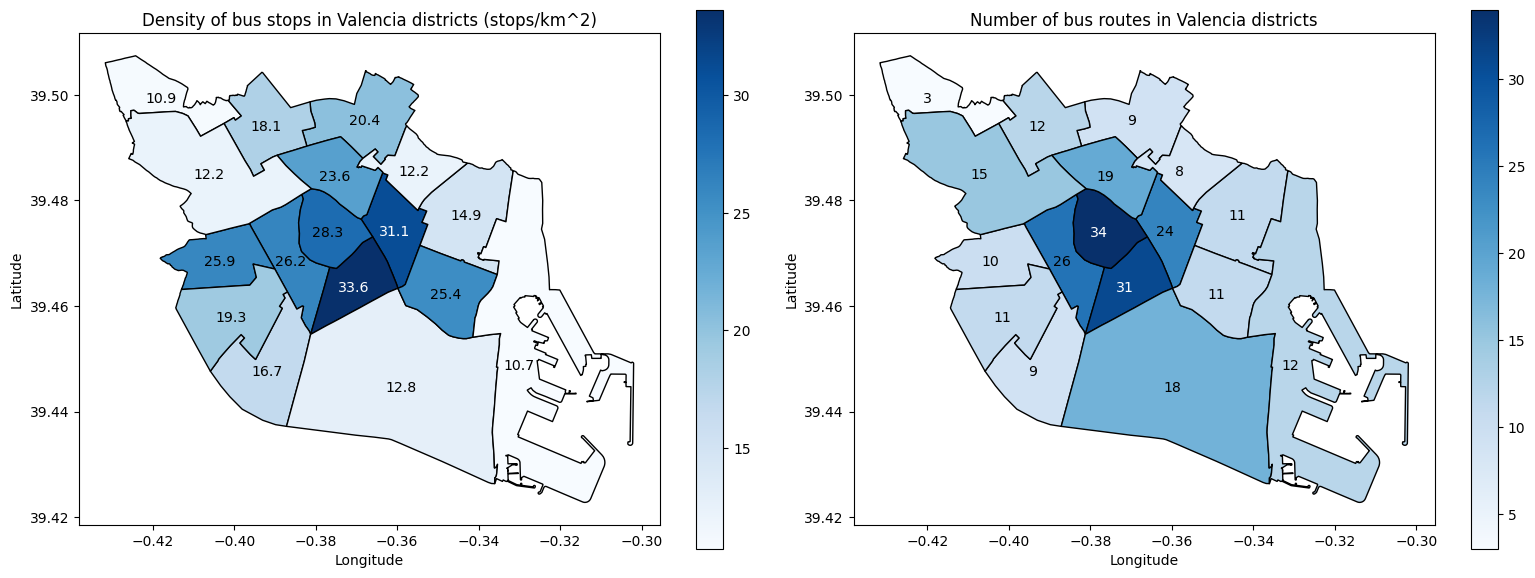

In [46]:
# Create a figure and two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot for stops_per_km2
merged_df.plot(ax=axs[0], column='stops_per_km2', cmap='Blues', edgecolor='black', legend=True, legend_kwds={'shrink': 0.7})

# Add annotations for stops_per_km2
for idx, row in merged_df.iterrows():
    axs[0].annotate(text=round(row['stops_per_km2'], 1),
                    xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                    xytext=(-22, -15) if row['nombre'] == 'POBLATS MARITIMS' else (-12, -5),
                    textcoords="offset points",
                    color='black' if row['stops_per_km2'] < 30 else 'white',
                    fontsize=10.2)

# Set title and labels for stops_per_km2 plot
axs[0].set_title('Density of bus stops in Valencia districts (stops/km^2)')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')

# Plot for routes_count
routes_merged_df.plot(ax=axs[1], column='routes_count', cmap='Blues', edgecolor='black', legend=True, legend_kwds={'shrink': 0.7})

# Add annotations for routes_count
for idx, row in routes_merged_df.iterrows():
    axs[1].annotate(text=row['routes_count'],
                    xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                    xytext=(-20, -15) if row['nombre'] == 'POBLATS MARITIMS' else (-10, -5),
                    textcoords="offset points",
                    color='black' if row['routes_count'] < 30 else 'white',
                    fontsize=10.2)

# Set title and labels for routes_count plot
axs[1].set_title('Number of bus routes in Valencia districts')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')

plt.tight_layout()
plt.savefig('../figures/density_routes_stops.png')
plt.show()

## Analysis of the frequencies of the bus service

In [47]:
# Rereading the data, as it should be in default state
frequencies_df = pd.read_csv('../data/frequencies.csv')
trips_df = pd.read_csv('../data/trips.csv')
shapes_df = pd.read_csv('../data/shapes.csv')

In [48]:
# Merge trips_df with frequencies_df
merged_trips_df = pd.merge(trips_df, frequencies_df, on='trip_id')

In [49]:
# Merge with shapes_df
merged_trips_df = pd.merge(merged_trips_df, shapes_df, on='shape_id')

In [50]:
# Cast merged_trips_df to GeoDataFrame
merged_trips_gdf = gpd.GeoDataFrame(merged_trips_df, geometry=gpd.points_from_xy(merged_trips_df['shape_pt_lon'], merged_trips_df['shape_pt_lat']))
merged_trips_gdf = merged_trips_gdf.set_crs(epsg=4326)

After the sequence of merges the dataframe has a lot of information: about the time range the trip is done, about the route_id, frequencies of the buses and sequence of the points on the road

In [51]:
merged_trips_gdf.head(1)

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id,start_time,end_time,headway_secs,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,geometry
0,28,FES,1034D2I,Ciutat Art. Faller,0,10342,SHP_1034_I,7:15:00,8:00:00,2700,39.467908,-0.378186,0,0.0,POINT (-0.37819 39.46791)


In [52]:
# Merge with key_district_stops_df to add information about the district
final_gdf = gpd.sjoin(districts_gdf, merged_trips_gdf, how='inner', predicate='intersects')
final_gdf.reset_index(inplace=True)

In [53]:
# Drop the unnecessary columns
final_gdf.drop(columns=['geometry', 'shape_pt_lat', 'shape_pt_lon', 'index', 'objectid', 'surface_area', 'index_right', 'trip_headsign', 'direction_id', 'route_id', 'service_id', 'trip_id', 'block_id', 'shape_id', 'shape_pt_sequence', 'shape_dist_traveled'], inplace=True)

Finally the wanted dataframe is obtained - it has the name of district, start time of the trip type, end time and frequency

In [54]:
final_gdf.head(1)

,nombre,start_time,end_time,headway_secs
0,EL PLA DEL REAL,8:23:00,8:46:00,1380


In [55]:
# Function to adjust hours exceeding 24
def adjust_hours(time_str):
    hours, minutes, seconds = map(int, time_str.split(':'))
    days, hours = divmod(hours, 24)
    return datetime.datetime(2024, 1, days + 1, hours, minutes, seconds)

In [56]:
# Convert start_time and end_time to datetime objects
final_gdf['start_time'] = final_gdf['start_time'].apply(adjust_hours)
final_gdf['end_time'] = final_gdf['end_time'].apply(adjust_hours)

In [57]:
# Arrays that will store the timestamps that buses stop in the district all in the whole city
algiros_timestamp = []
camins_al_grau_timestamp = []
benimaclet_timestamp = []
poblats_maritims_timestamp = []
all_timestamp = []

In [58]:
for _, row in final_gdf.iterrows():
    timestamps = []
    start_time = row['start_time']
    end_time = row['end_time']
    headway_secs = row['headway_secs']
    timestamp = start_time
    while timestamp <= end_time:
        timestamps.append(timestamp)
        timestamp += pd.Timedelta(seconds=headway_secs)


    if row['nombre'] == 'ALGIROS':
        algiros_timestamp.extend(timestamps)
    elif row['nombre'] == 'CAMINS AL GRAU':
        camins_al_grau_timestamp.extend(timestamps)
    elif row['nombre'] == 'BENIMACLET':
        benimaclet_timestamp.extend(timestamps)
    elif row['nombre'] == 'POBLATS MARITIMS':
        poblats_maritims_timestamp.extend(timestamps)
    all_timestamp.extend(timestamps)

In [59]:
# The timestamps are sorted in the arrays
algiros_timestamp = sorted(algiros_timestamp)
camins_al_grau_timestamp = sorted(camins_al_grau_timestamp)
benimaclet_timestamp = sorted(benimaclet_timestamp)
poblats_maritims_timestamp = sorted(poblats_maritims_timestamp)
all_timestamp = sorted(all_timestamp)

In [60]:
# The dataframes are created
algiros_df = pd.DataFrame(algiros_timestamp, columns=['timestamp'])
camins_al_grau_df = pd.DataFrame(camins_al_grau_timestamp, columns=['timestamp'])
benimaclet_df = pd.DataFrame(benimaclet_timestamp, columns=['timestamp'])
poblats_maritims_df = pd.DataFrame(poblats_maritims_timestamp, columns=['timestamp'])
all_df = pd.DataFrame(all_timestamp, columns=['timestamp'])

In [61]:
# For each timestamp the number of occurrences is counted
algiros_df = algiros_df.groupby('timestamp').size().reset_index()
camins_al_grau_df = camins_al_grau_df.groupby('timestamp').size().reset_index()
benimaclet_df = benimaclet_df.groupby('timestamp').size().reset_index()
poblats_maritims_df = poblats_maritims_df.groupby('timestamp').size().reset_index()
all_df = all_df.groupby('timestamp').size().reset_index()

In [62]:
# Function to count the visits on the bus stops in the time interval of 30 minutes.
def count_entries(df):
    # Generate a list of timestamps at 30-minute intervals from 5:00 to 3:00
    timestamps = pd.date_range(start='2024-01-01 05:00:00', end='2024-01-02 03:00:00', freq='30min')
    # Initialize an empty list to store the counts
    counts = []

    # Iterate over the timestamps
    for timestamp in timestamps:
        # Calculate the start and end of the 30-minute window
        window_start = timestamp
        window_end = timestamp + pd.Timedelta(minutes=30)
        
        # Count the number of entries in the DataFrame that fall within the window
        count = ((df['timestamp'] >= window_start) & (df['timestamp'] < window_end)).sum()
        
        # Append the count to the list of counts
        counts.append(count)

    # Create a new DataFrame with the timestamps and counts
    df = pd.DataFrame({'timestamp': timestamps, 'count': counts})
    
    df['timestamp'] = df['timestamp'].dt.strftime('%H:%M')
    
    return df

In [63]:
algiros_df = count_entries(algiros_df)
camins_al_grau_df = count_entries(camins_al_grau_df)
benimaclet_df = count_entries(benimaclet_df)
poblats_maritims_df = count_entries(poblats_maritims_df)
all_df = count_entries(all_df)

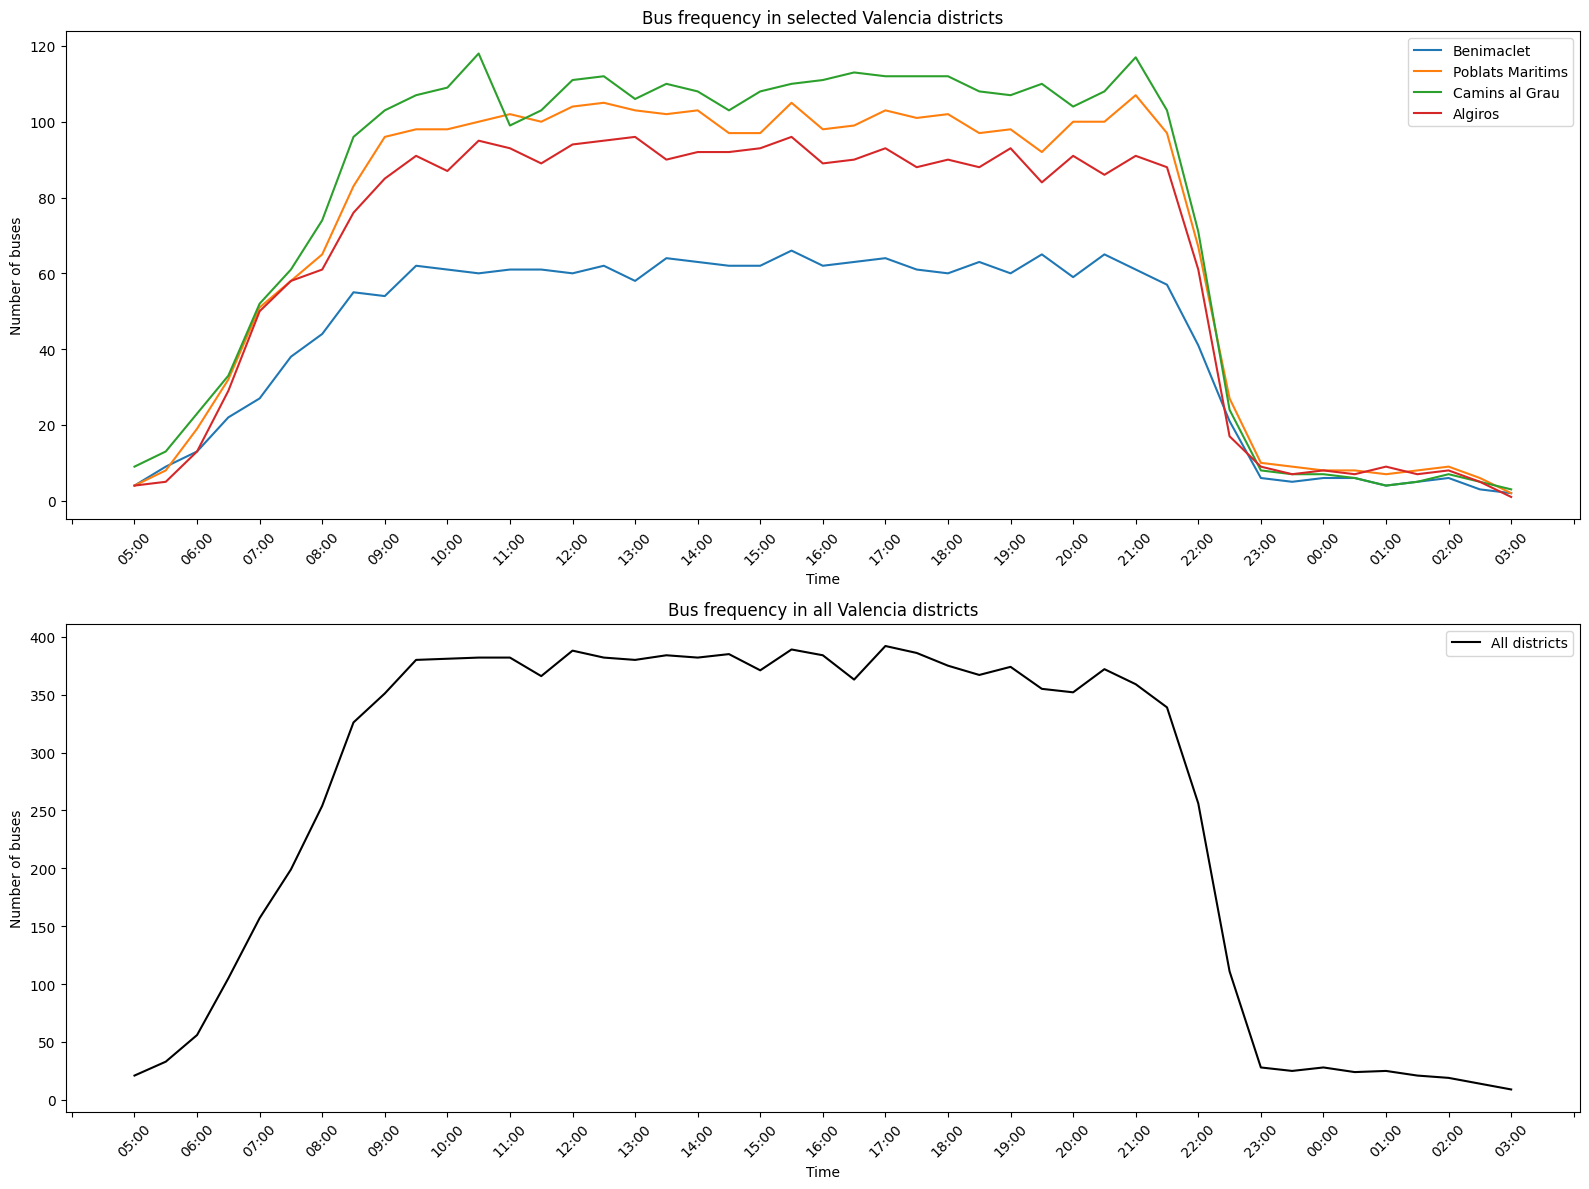

In [64]:
# Create a figure and subplots
fig, axs = plt.subplots(2, 1, figsize=(16, 12))

# Subplot 1: Benimaclet, Poblats Maritims, Camins al Grau, and Algiros
axs[0].plot(benimaclet_df['timestamp'], benimaclet_df['count'], label='Benimaclet')
axs[0].plot(poblats_maritims_df['timestamp'], poblats_maritims_df['count'], label='Poblats Maritims')
axs[0].plot(camins_al_grau_df['timestamp'], camins_al_grau_df['count'], label='Camins al Grau')
axs[0].plot(algiros_df['timestamp'], algiros_df['count'], label='Algiros')
axs[0].set_title('Bus frequency in selected Valencia districts')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Number of buses')
axs[0].tick_params(axis='x', rotation=45)
axs[0].legend()

# Subplot 2: All districts
axs[1].plot(all_df['timestamp'], all_df['count'], color='black', label='All districts')
axs[1].set_title('Bus frequency in all Valencia districts')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Number of buses')
axs[1].tick_params(axis='x', rotation=45)
axs[1].legend()

for ax in axs:
    ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=30))  # Show every second tick

# Adjust layout
plt.tight_layout()
plt.savefig('../figures/bus_frequency.png')

# Display the plot
plt.show()


## Combination with survey analysis

### Number of lines going directly to the City of Arts and Sciences

In [65]:
# Information about the name of the districts and the route ids
connections_gdf = final_joined_gdf[['route_id', 'nombre']]

In [66]:
# List of routes that stop close to City of Arts and Sciences
city_of_arts_buses = [13, 14, 18, 19, 23, 24, 25, 35, 40, 94, 95, 99]

In [67]:
# Creating the list of the routes that go through each district, set of the routes that go through the district and stop close to City of Arts and Sciences, and the number of routes that go through the district and stop
# close to City of Arts and Sciences and number of such routes
connections_gdf = connections_gdf.groupby('nombre')['route_id'].unique().reset_index()
connections_gdf.rename(columns={'route_id': 'routes_list'}, inplace=True)
connections_gdf['routes_through_city_of_arts'] = connections_gdf['routes_list'].apply(lambda x: set(x).intersection(city_of_arts_buses))
connections_gdf['routes_through_city_of_arts_number'] = connections_gdf['routes_through_city_of_arts'].apply(lambda x: len(x))

In [68]:
# Mean number of routes per district that go through the district and stop close to City of Arts and Sciences
mean_routes = connections_gdf['routes_through_city_of_arts_number'].mean()

print(f'Mean number of routes per district that go through the district and stop close to City of Arts and Sciences: {mean_routes:.2f}')

Mean number of routes per district that go through the district and stop close to City of Arts and Sciences: 3.11


Connections_gdf have stores the list of routes that go through each residential area, the set of lines number that go through the area and stops close to the City of Arts and Sciences and the number of such lines

In [69]:
connections_gdf

,nombre,routes_list,routes_through_city_of_arts,routes_through_city_of_arts_number
0,ALGIROS,"[18, 30, 31, 32, 40, 71, 81, 89, 39, 38, 93]","{40, 18}",2
1,BENICALAP,"[63, 28, 12, 26, 60, 62, 89, 90, 64, 94, 92, 39]",{94},1
2,BENIMACLET,"[10, 11, 12, 70, 89, 90, 38, 93]",{},0
3,CAMINS AL GRAU,"[4, 18, 19, 30, 32, 35, 40, 89, 94, 92, 39]","{35, 40, 18, 19, 94}",5
4,CAMPANAR,"[63, 28, 95, 60, 62, 79, 80, 89, 90, 64, 67, 9...","{94, 95}",2
5,CIUTAT VELLA,"[23, 24, 63, 28, 95, 4, 6, 7, 8, 9, 10, 11, 13...","{35, 40, 13, 14, 19, 23, 24, 25, 94, 95}",10
6,EL PLA DEL REAL,"[95, 4, 6, 10, 11, 12, 16, 18, 19, 26, 30, 31,...","{18, 19, 94, 95}",4
7,EXTRAMURS,"[63, 28, 95, 7, 8, 9, 10, 11, 19, 27, 31, 60, ...","{19, 95}",2
8,JESUS,"[9, 10, 11, 18, 27, 89, 90, 64, 39]",{18},1
9,L'EIXAMPLE,"[23, 24, 95, 4, 6, 7, 8, 10, 11, 12, 13, 14, 1...","{35, 40, 13, 14, 18, 19, 23, 24, 25, 94, 95}",11


### Evaluation of landmark connections to the residential area

In [70]:
# Read the data obtained from the survey spreadsheet
areas_df = pd.read_csv('../data/areas.csv')

In [71]:
areas_df

,area,num_of_responses,CityArtsScienceMean,CityArtsScienceMedian,BeachMean,BeachMedian,OldTownMean,OldTownMedian
0,Total,104,2.99,3.0,3.90,4.0,3.63,4.0
1,Poblados Marítimos,16,3.73,4.0,4.67,5.0,3.33,3.0
2,Algirós,26,2.80,3.0,4.17,4.0,3.77,4.0
3,Camins al Grau,17,3.12,3.0,4.12,4.5,3.87,4.0
4,Benimaclet,15,2.62,2.0,4.00,4.0,3.50,3.5
5,Eixample,5,3.75,3.5,3.00,3.0,3.50,3.5
6,El Pla del Real,8,2.25,2.0,3.62,3.0,4.00,4.0
7,Ciutat Vella,5,2.80,3.0,2.80,3.0,3.00,3.0


In [72]:
# Changes to make the merging possible
areas_df['area'] = areas_df['area'].apply(lambda x: x.upper())
areas_df.loc[1, 'area'] = 'POBLATS MARITIMS'
areas_df.loc[2, 'area'] = 'ALGIROS'
areas_df.loc[5, 'area'] = 'L\'EIXAMPLE'

In [73]:
# Merging droping the unnecessary columns, droping far away districts and taking care of none values
areas_df = districts_gdf.merge(areas_df, left_on='nombre', right_on='area', how='left')
areas_df.drop(columns=['objectid', 'area', 'surface_area', 'num_of_responses', 'CityArtsScienceMedian', 'BeachMedian', 'OldTownMedian'], inplace=True)
areas_df.fillna(0, inplace=True)
areas_df.drop([7, 12, 14], inplace=True)

areas_df contains information about the borders of the district, its name and the mean values of evaluation of its connection with the landmarks

In [74]:
areas_df.head(1)

,nombre,geometry,CityArtsScienceMean,BeachMean,OldTownMean
0,EL PLA DEL REAL,"POLYGON ((-0.36229 39.48483, -0.36274 39.48389...",2.25,3.62,4.0


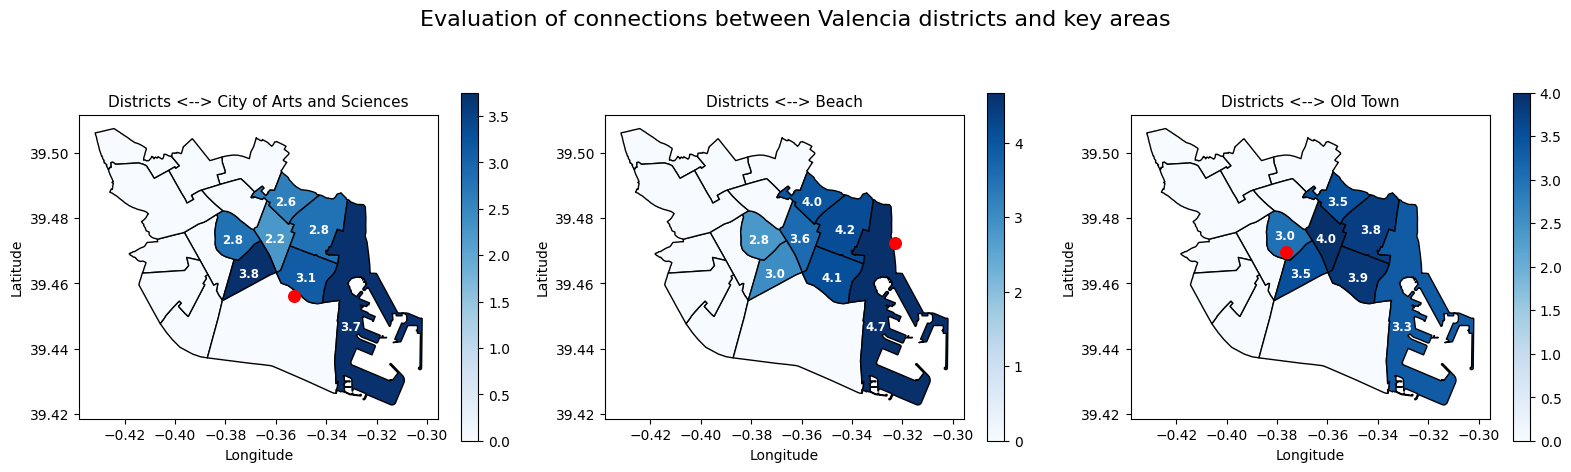

In [75]:
# Plot that shows mean grades of the connections between the districts and the key areas
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
plt.suptitle('Evaluation of connections between Valencia districts and key areas', fontsize=16)

# Plot the data about mean value of connectedness to the city of arts and sciences on the first subplot
areas_df.plot(ax=axs[0], column='CityArtsScienceMean', cmap='Blues', edgecolor='black', legend=True, legend_kwds={'shrink': 0.8})

# Add annotations for districts
for idx, row in areas_df.iterrows():
    axs[0].annotate(text=round(row['CityArtsScienceMean'], 1) if row['CityArtsScienceMean'] > 0 else '',
                    xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                    xytext=(-15, -15) if row['nombre'] == 'POBLATS MARITIMS' else (-8, -5),
                    textcoords="offset points",
                    color='white',
                    fontsize=8.5,
                    fontweight='bold')
    
# Add a red point in the location of city of arts and sciences
axs[0].scatter(-0.352847, 39.456049, color='red', s=70)
# Set title and labels for the first plot
axs[0].set_title('Districts <--> City of Arts and Sciences', fontsize=11)
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')

# Plot the data about mean value of connectedness to the beach on the second subplot
areas_df.plot(ax=axs[1], column='BeachMean', cmap='Blues', edgecolor='black', legend=True, legend_kwds={'shrink': 0.8})

# Add annotations for districts
for idx, row in areas_df.iterrows():
    axs[1].annotate(text=round(row['BeachMean'], 1) if row['BeachMean'] > 0 else '',
                    xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                    xytext=(-15, -15) if row['nombre'] == 'POBLATS MARITIMS' else (-8, -5),
                    textcoords="offset points",
                    color='white',
                    fontsize=8.5,
                    fontweight='bold')
    
# Add a red point in the location of the beach
axs[1].scatter(-0.323003, 39.472252, color='red', s=70)
# Set title and labels for the second plot
axs[1].set_title('Districts <--> Beach', fontsize=11)
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')

# Plot the data about mean value of connectedness to the old town on the third subplot
areas_df.plot(ax=axs[2], column='OldTownMean', cmap='Blues', edgecolor='black', legend=True, legend_kwds={'shrink': 0.8})

# Add annotations for districts
for idx, row in areas_df.iterrows():
    axs[2].annotate(text=round(row['OldTownMean'], 1) if row['OldTownMean'] > 0 else '',
                    xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                    xytext=(-15, -15) if row['nombre'] == 'POBLATS MARITIMS' else ((-8, -2) if row['nombre'] == 'CIUTAT VELLA' else(-8, -5)),
                    textcoords="offset points",
                    color='white',
                    fontsize=8.5,
                    fontweight='bold')
    
# Add a red point in the location of the old town
axs[2].scatter(-0.376321, 39.469650, color='red', s=70)
# Set title and labels for the third plot
axs[2].set_title('Districts <--> Old Town', fontsize=11)
axs[2].set_xlabel('Longitude')
axs[2].set_ylabel('Latitude')


plt.tight_layout()
plt.savefig('../figures/connections_evaluation.png')
plt.show()